In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.distributions as dist\
    
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')
# %matplotlib inline


In [3]:
from geobed.continuous.core import BED_Class

/home/dstrutz/sshfs/Libs/GeoBED/geobed/continuous/core.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# model prior
a_2_mean = torch.tensor([3750.0])
a_2_std = torch.tensor([300.0])
m_prior_dist = dist.Independent(dist.Normal(a_2_mean, a_2_std), 1)

# nuisance prior
a_1_model = torch.tensor(2750.0)
d_model   = torch.tensor(500.0 )

# nuisance_parameter_samples = torch.tensor([a_1_model, d_model])

In [5]:
from geobed.fwd_collection.avo import *

def forward_function(design, model_samples, **kwargs):   
    return calculate_avo(design[..., None], a_1_model, model_samples[..., None], d_model).permute(0, 2, 1) # add nuisance dimension

In [6]:
def data_likelihood_avo(samples, design=None, **kwargs):
    std_data = 0.05
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor(std_data)), 1)
    
    return data_likelihood

In [7]:
Test_BED_Class = BED_Class(
    forward_function=forward_function,
    obs_noise_dist=data_likelihood_avo,
    m_prior_dist=m_prior_dist,
    # m_prior_samples=,
    # nuisance_parameter_dist=,
    # nuisance_parameter_samples=nuisance_parameter_samples,
    )

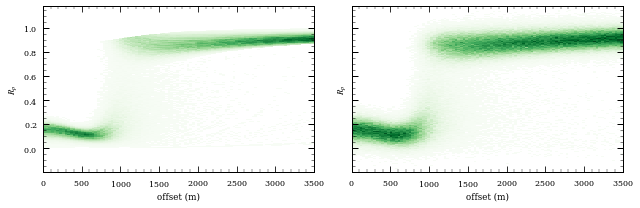

In [8]:
n_visual_model_samples = int(1e4)
n_designs = 100
design_list = torch.linspace(0, 3500, 100).unsqueeze(-1)

clean_data = Test_BED_Class.get_forward_function_samples(
    design_list.squeeze(),
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=1,
    random_seed_model=1,
    random_seed_nuisance=2,
    ).squeeze()

noisy_data = Test_BED_Class.get_forward_model_samples(
    design_list.squeeze(),
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=1,
    random_seed_model=1,
    random_seed_nuisance=2,
    ).squeeze() 

# with style.context('./mpl_stylesheet.mplstyle'):
fig = plt.figure(figsize=(9, 3))
ax_dict = fig.subplot_mosaic(
    '''ab''',
    # gridspec_kw={'wspace': 0.2},
    sharex=True, sharey=True)

ax_dict['a'].hist2d(design_list.squeeze().expand(n_visual_model_samples, -1).flatten().numpy(),
                    clean_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(design_list.squeeze().expand(n_visual_model_samples, -1).flatten().numpy(),
                    noisy_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)
    
ax_dict['a'].set_ylabel(r'$R_p$')
ax_dict['b'].set_ylabel(r'$R_p$')

ax_dict['a'].set_xlabel('offset (m)')
ax_dict['b'].set_xlabel('offset (m)')

plt.tight_layout()
plt.show()

In [9]:
num_workers = 10

In [10]:
T = int(1e3)

eig_nmc, out_nmc = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='NMC',
    # eig_method_kwargs={'N': int(T//2), 'M': int(T//2), 'reuse_M':False, 'memory_efficient':False},
    eig_method_kwargs={'N': T, 'reuse_M':True, 'memory_efficient':False},
    num_workers=1,
    parallel_library='joblib',
    random_seed=0,
)

Calculating eig:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
eig_dn, out_dn = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='DN',
    eig_method_kwargs={'N': int(1e3)},
    num_workers=num_workers,
    parallel_library='joblib',
    random_seed=0,
)

Calculating eig:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
# from geobed.discrete.guides import GMM_guide

# T = int(1e3)
# N = T//2
# M = T//2
# n_batch = 10
# n_epochs = 10

# scheduler = torch.optim.lr_scheduler.ExponentialLR
# max_lr = 1e-1
# min_lr = 1e-2
# gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

# eig_varmarg, out_varmarg = Test_BED_Class.calculate_EIG(
#     design=design_list,
#     eig_method='variational_marginal',
#     eig_method_kwargs=
#         {'guide': GMM_guide,
#         'N': N,
#         'M': M,
#         'guide_kwargs': {'components':5, 'init_method': {'init_params': 'k-means++', 'n_init': 10, 'max_iter': 1}},
#         'n_batch': n_batch,
#         'n_epochs': n_epochs,
#         # 'optimizer': None,
#         'optimizer_kwargs': {'lr': max_lr},
#         'scheduler': scheduler,
#         'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
#         'return_guide': True,
#         'return_train_loss': True,
#         'return_test_loss': True,
#         },
#     num_workers=num_workers,
#     parallel_library='joblib',
#     random_seed=0,
# )

# plt.figure(figsize=(10, 3))
# plt.plot(out_varmarg[0]['train_loss'], label='train loss')
# plt.show()

In [13]:
# from geobed.discrete.guides import MDN_guide

# T = int(1e3)
# N = T//2
# M = T//2
# n_batch = 10
# n_epochs = 10

# scheduler = torch.optim.lr_scheduler.ExponentialLR
# max_lr = 1e-4
# min_lr = 1e-6
# gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

# eig_varpost, out_varpost = Test_BED_Class.calculate_EIG(
#     design=design_list,
#     eig_method='variational_posterior',
#     eig_method_kwargs=
#         {'guide': MDN_guide,
#         'N': N,
#         'M': M,
#         'guide_kwargs': {'components':10, 'hidden_features':[50, 50, 50], 'normalize':True},
#         'n_batch': n_batch,
#         'n_epochs': n_epochs,
#         # 'optimizer': None,
#         'optimizer_kwargs': {'lr': max_lr},
#         'scheduler': scheduler,
#         'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
#         'return_guide': True,
#         'return_train_loss': True,
#         'return_test_loss': True,
#         },
#     num_workers=num_workers,
#     parallel_library='joblib',
#     random_seed=0,
# )

# plt.figure(figsize=(10, 3))
# plt.plot(out_varpost[0]['train_loss'], label='train loss')
# plt.show()

In [14]:
# from geobed.discrete.guides import MLP_FLO
    
# T = int(1e3)
# N = T//2
# M = T//2
# n_batch = 10
# n_epochs = 10

# scheduler = torch.optim.lr_scheduler.ExponentialLR
# max_lr = 1e-3
# min_lr = 1e-4
# gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

# eig_FLO, out_FLO = Test_BED_Class.calculate_EIG(
#     design=design_list,
#     eig_method='FLO',
#     eig_method_kwargs=
#         {'guide': MLP_FLO,
#         'N': N,
#         'M': M,
#         'K': 'adaptive',
#         # 'guide_kwargs': {'H':[100, 100, 100, 100,],},
#         'guide_kwargs': {'H':[100, 100,],},
#         'n_batch': n_batch,
#         'n_epochs': n_epochs,
#         # 'optimizer': None,
#         'optimizer_kwargs': {'lr': max_lr},
#         'scheduler': scheduler,
#         'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
#         'return_guide': True,
#         'return_train_loss': True,
#         'return_test_loss': True,
#         },
#     num_workers=num_workers,
#     parallel_library='joblib',
#     random_seed=0,
# )

# plt.figure(figsize=(10, 6))
# plt.plot(out_FLO[0]['train_loss'], label='train loss')
# plt.show()

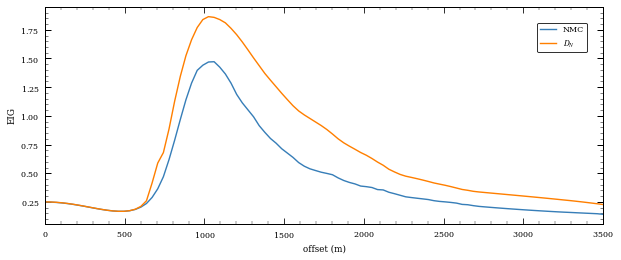

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(design_list, eig_nmc, label=r'NMC')
ax.plot(design_list, eig_dn, label=r'$D_{N}$')
# ax.plot(design_list, eig_varmarg, label=r'Var Marg')
# ax.plot(design_list, eig_varpost, label=r'Var Post')
# ax.plot(design_list, eig_FLO, label=r'FLO')

ax.set_xlabel('offset (m)')
ax.set_ylabel('EIG')

ax.set_xlim([0, 3500])

ax.legend()
# ax.grid()

plt.show()